# Gestion Energétique en Zone Urbaine - Exercice

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_folder = "donnees"

os.listdir(data_folder)

['layer_buildings.shx',
 'layer_buildings.sbx',
 'layer_buildings.sbn',
 'consommations_specifiques.csv',
 'layer_buildings.shp',
 'layer_buildings.shp.xml',
 'donnees_batiments.csv',
 'layer_buildings.dbf',
 'layer_buildings.prj',
 'agent_ener_perf.csv']

## Récupération des données
Les données concernant les bâtiments de la zone d'étude se trouvent dans le fichier `donnees_batiments.csv`.

In [2]:
raw_data = pd.read_csv(os.path.join(data_folder, 'donnees_batiments.csv'), index_col=0)
raw_data.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2]
ID,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518
2,Batiment commercial,2011-2015,Mazout,1,1203
3,Immeuble de bureaux,1971-1980,Electricite,3,428
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275


Les consommations spécifiques des bâtiments (en kWh/m2/an) sont des valeurs statistiques moyennes standardisées.
Elles seront utilisées pour estimer l'énergie utile nécessaire pour chauffer les bâtiments de la zone d'étude.
Ces données sont présentes dans le fichier `consommations_specifiques.csv`.

In [3]:
c_spec = pd.read_csv(os.path.join(data_folder, 'consommations_specifiques.csv'), index_col=0)
c_spec.head()

,1900-1920,1921-1945,1946-1960,1961-1970,1971-1980,1981-1985,1986-1990,1991-1995,1996-2000,2001-2005,2006-2010,2011-2015
TypeAffectation,,,,,,,,,,,,
Batiment commercial,124,140,140,137,124,101,85,68,68,52,52,39
Batiment culturel,158,179,179,175,158,129,108,87,87,67,67,50
Batiment industriel,137,155,155,151,137,112,94,76,76,58,58,43
Entrepot,107,121,121,118,107,87,73,59,59,45,45,34
Hopital,216,244,244,238,216,176,148,119,119,91,91,68


Les facteurs permettant de calculer l'énergie finale, l'énergie primaire et les rejets de CO2 associés aux besoins de chauffage des bâtiments sont disponibles dans le fichier `agent_ener_perf.csv`.

In [4]:
perf_ae = pd.read_csv(os.path.join(data_folder, 'agent_ener_perf.csv'), index_col=0)
perf_ae.head()

,Factor_E_prim_[ep/ef],CO2_[kgCO2/MJ_ef],Eff_[eu/ef]
AE,,,
Pas d'agent,0.00,0.0000,0.0
Mazout,1.24,0.2952,0.9
Charbon,1.66,0.4320,0.8
Gaz naturel,1.15,0.2412,0.9
Electricite,2.34,0.0800,1.0


## 1. Calcul de la Surface de Référence Energétique (SRE)
Les différents calculs se font sur une copie des données.

$SRE = 0.9 * Empreinte \: au \: sol* Nombre \: de \: niveaux$

In [5]:
data = raw_data.copy()

ratio_sre = 0.9
data["SRE_[m2]"] = ratio_sre * data["EmpreinteSol_[m2]"] * data["NbrNiveauxChauffes"]
data.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2],SRE_[m2]
ID,,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518,1398.6
2,Batiment commercial,2011-2015,Mazout,1,1203,1082.7
3,Immeuble de bureaux,1971-1980,Electricite,3,428,1155.6
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985,3546.0
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275,4590.0


## 2. Estimation de l'énergie utile
$E_{utile} = SRE * conso_{specifique}$

In [6]:
def e_utile(row):
    return row["SRE_[m2]"] * c_spec.at[row["TypeAffectation"], row["PeriodeConstruction"]]

data["E_utile_[kWh/an]"] = data.apply(e_utile, axis=1)
data.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2],SRE_[m2],E_utile_[kWh/an]
ID,,,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518,1398.6,176223.6
2,Batiment commercial,2011-2015,Mazout,1,1203,1082.7,42225.3
3,Immeuble de bureaux,1971-1980,Electricite,3,428,1155.6,179118.0
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985,3546.0,446796.0
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275,4590.0,711450.0


## 3. Estimation de l'énergie finale
$E_{finale} = \frac{E_{finale}}{rendement_{agent \: énergétique}}$

In [7]:
def e_finale(row):
    return round(row["E_utile_[kWh/an]"] / perf_ae.at[row["AgentEnergetique"], "Eff_[eu/ef]"], 1)

data["E_finale_[kWh/an]"] = data.apply(e_finale, axis=1)
data.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2],SRE_[m2],E_utile_[kWh/an],E_finale_[kWh/an]
ID,,,,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518,1398.6,176223.6,195804.0
2,Batiment commercial,2011-2015,Mazout,1,1203,1082.7,42225.3,46917.0
3,Immeuble de bureaux,1971-1980,Electricite,3,428,1155.6,179118.0,179118.0
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985,3546.0,446796.0,496440.0
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275,4590.0,711450.0,790500.0


## 4. Estimation de l'énergie primaire
$E_{primaire} = E_{finale} * facteur_{E_p/E_f}$

In [8]:
def e_primaire(row):
    return round(row["E_finale_[kWh/an]"] * perf_ae.at[row["AgentEnergetique"], "Factor_E_prim_[ep/ef]"], 1)

data["E_primaire_[kWh/an]"] = data.apply(e_primaire, axis=1)
data.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2],SRE_[m2],E_utile_[kWh/an],E_finale_[kWh/an],E_primaire_[kWh/an]
ID,,,,,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518,1398.6,176223.6,195804.0,242797.0
2,Batiment commercial,2011-2015,Mazout,1,1203,1082.7,42225.3,46917.0,58177.1
3,Immeuble de bureaux,1971-1980,Electricite,3,428,1155.6,179118.0,179118.0,419136.1
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985,3546.0,446796.0,496440.0,570906.0
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275,4590.0,711450.0,790500.0,909075.0


## 5. Estimation des rejets de CO2
$Rejets_{CO_2} = E_{finale} * facteur_{CO_2}$

In [9]:
def rej_co2(row):
    return round(row["E_finale_[kWh/an]"] * 3.6 * perf_ae.at[row["AgentEnergetique"], "CO2_[kgCO2/MJ_ef]"] * 1e-3, 1)

data["RejCO2_[Tco2/an]"] = data.apply(rej_co2, axis=1)
data.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2],SRE_[m2],E_utile_[kWh/an],E_finale_[kWh/an],E_primaire_[kWh/an],RejCO2_[Tco2/an]
ID,,,,,,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518,1398.6,176223.6,195804.0,242797.0,208.1
2,Batiment commercial,2011-2015,Mazout,1,1203,1082.7,42225.3,46917.0,58177.1,49.9
3,Immeuble de bureaux,1971-1980,Electricite,3,428,1155.6,179118.0,179118.0,419136.1,51.6
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985,3546.0,446796.0,496440.0,570906.0,431.1
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275,4590.0,711450.0,790500.0,909075.0,686.4


## 6. Estimation de la puissance thermique installée
$P_{installée} = \frac{E_{finale}}{equivalent \: heures\:  pleine \: charge}$

In [10]:
ehpc = 2300
data["P_[kW]"] = round(data["E_utile_[kWh/an]"] / ehpc, 1)
data.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2],SRE_[m2],E_utile_[kWh/an],E_finale_[kWh/an],E_primaire_[kWh/an],RejCO2_[Tco2/an],P_[kW]
ID,,,,,,,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518,1398.6,176223.6,195804.0,242797.0,208.1,76.6
2,Batiment commercial,2011-2015,Mazout,1,1203,1082.7,42225.3,46917.0,58177.1,49.9,18.4
3,Immeuble de bureaux,1971-1980,Electricite,3,428,1155.6,179118.0,179118.0,419136.1,51.6,77.9
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985,3546.0,446796.0,496440.0,570906.0,431.1,194.3
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275,4590.0,711450.0,790500.0,909075.0,686.4,309.3


## 7. Bilan des installations existantes (et export vers csv)

In [11]:
data[["E_utile_[kWh/an]", "E_finale_[kWh/an]", "E_primaire_[kWh/an]", "RejCO2_[Tco2/an]", "P_[kW]"]].sum()

E_utile_[kWh/an]        8665325.1
E_finale_[kWh/an]       9559455.8
E_primaire_[kWh/an]    12280316.7
RejCO2_[Tco2/an]           9132.7
P_[kW]                     3767.5
dtype: float64

In [12]:
data.to_csv("resultats.csv")

## 8. Estimation des ressources disponibles
#### Blanchisserie

In [13]:
cp_eau = 4.185  # [kJ/kg.K]

dt_blanc = 45 - 12  # [deg.C]
flow_blanc = 5  #  [l/s]

p_blanc = dt_blanc * flow_blanc * cp_eau
e_blanc = p_blanc * 365 * 24 * 1e-6
print(int(p_blanc), 'kW')
print('Production totale:', int(p_blanc * 365 * 24 * 1e-3), 'MWh')

690 kW
Production totale: 6048 MWh


#### UIOM

In [14]:
d = 5  # [h/j]
t_rej = 100  # [deg.C]
t_amb = 25  # [deg.C]
flow = 300  # [m3/h]
cp_fumees = 1.048  # [kJ/kg.K]

rho = 1.2  # [kg/m3]

p_uiom = flow * (t_rej - t_amb) * cp_fumees * rho / 3600
print(p_uiom, 'kW')
print('Production totale:', int(p_uiom * 5 * 365 * 9/12 * 1e-3), 'MWh')

7.86 kW
Production totale: 10 MWh


#### STEP

In [15]:
dt_hiver = 2  # [deg.C]
dt_ete = 6  # [deg.C]

flow_jour = 300  # [l/s]
flow_nuit = 50  # [l/s]

p_hiver_jour = dt_hiver * flow_jour * cp_eau
p_ete_jour = dt_ete * flow_jour * cp_eau
p_hiver_nuit = dt_hiver * flow_nuit * cp_eau
p_ete_nuit = dt_ete * flow_nuit * cp_eau

print('H+J:', int(p_hiver_jour), 'kW')
print('E+J:', int(p_ete_jour), 'kW')
print('H+N:', int(p_hiver_nuit), 'kW')
print('E+N:', int(p_ete_nuit), 'kW')

e_step = 365 * 24 * p_hiver_nuit * 1e-6
print('Production totale (uniquement puissance hiver/nuit):', int(365 * 24 * p_hiver_nuit * 1e-3), 'MWh')

H+J: 2510 kW
E+J: 7532 kW
H+N: 418 kW
E+N: 1255 kW
Production totale (uniquement puissance hiver/nuit): 3666 MWh


#### Solaire thermique

In [16]:
irr = 3.54  # [kWh/m2/jour]
eff_solth = 0.35

def e_solaire(row):
    if row["EmpreinteSol_[m2]"] > 250:
        return eff_solth * irr * 365 * 0.7 * row["EmpreinteSol_[m2]"]
    else:
        return eff_solth * irr * 365 * 0.4 * row["EmpreinteSol_[m2]"]
    
e_solaire = data.apply(e_solaire, axis=1)
print("Production totale", round(e_solaire.sum()*1e-3), "MWh")

Production totale 8619.0 MWh


In [17]:
ae_grp = data.groupby("AgentEnergetique").sum()
ae_grp

,NbrNiveauxChauffes,EmpreinteSol_[m2],SRE_[m2],E_utile_[kWh/an],E_finale_[kWh/an],E_primaire_[kWh/an],RejCO2_[Tco2/an],P_[kW]
AgentEnergetique,,,,,,,,
Electricite,11,3248,5508.0,618148.8,618148.8,1446468.2,178.0,268.7
Gaz naturel,22,8013,19870.2,2533723.2,2815248.0,3237535.2,2444.5,1101.6
Mazout,40,16120,42416.1,5513453.1,6126059.0,7596313.3,6510.2,2397.2


<IPython.core.display.Javascript object>


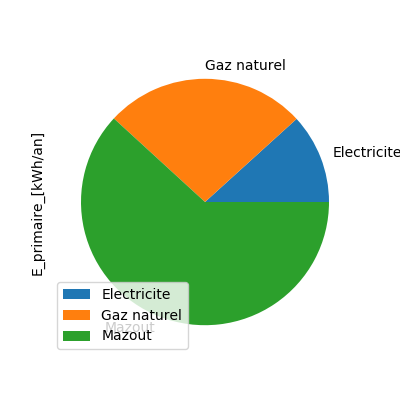

In [18]:
%matplotlib notebook
ae_grp.plot.pie(y="E_primaire_[kWh/an]", figsize=(4, 4))

## 9a. Creation d'un scenario 1

In [19]:
data_sce1 = raw_data.copy()
data_sce1.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2]
ID,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518
2,Batiment commercial,2011-2015,Mazout,1,1203
3,Immeuble de bureaux,1971-1980,Electricite,3,428
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275


In [20]:
list_per = sorted(data_sce1.PeriodeConstruction.unique())[:3]
print(list_per)
# Rénnovation de tous les bâtiments avant 1960
data_sce1.loc[data_sce1.PeriodeConstruction.isin(list_per), "PeriodeConstruction"] = "2011-2015"
# Remplacement du Mazout par le gaz naturel
data_sce1.loc[data_sce1.AgentEnergetique == "Mazout", "AgentEnergetique"] = "Gaz naturel"
data_sce1.head()

['1900-1920', '1921-1945', '1946-1960']


,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2]
ID,,,,,
1,Immeuble de bureaux,1981-1985,Gaz naturel,3,518
2,Batiment commercial,2011-2015,Gaz naturel,1,1203
3,Immeuble de bureaux,1971-1980,Electricite,3,428
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275


## 9b. Création d'un scénario 2

In [21]:
eff_cad = 0.85
cop_pac = 4.0

# Creation d'un agent énergétique avec la STEP et la blanchisserie (PaC et Cad associés)

perf_ae.loc["RessourcesLocales_PaC+CaD"] = [2.34, 0.08, eff_cad*cop_pac]
perf_ae.loc["RessourcesLocales_PaC+CaD"]

Factor_E_prim_[ep/ef]    2.34
CO2_[kgCO2/MJ_ef]        0.08
Eff_[eu/ef]              3.40
Name: RessourcesLocales_PaC+CaD, dtype: float64

In [22]:
data_sce2 = raw_data.copy()
data_sce2.head()

,TypeAffectation,PeriodeConstruction,AgentEnergetique,NbrNiveauxChauffes,EmpreinteSol_[m2]
ID,,,,,
1,Immeuble de bureaux,1981-1985,Mazout,3,518
2,Batiment commercial,2011-2015,Mazout,1,1203
3,Immeuble de bureaux,1971-1980,Electricite,3,428
4,Immeuble de bureaux,1981-1985,Gaz naturel,4,985
5,Maison mitoyenne,1981-1985,Gaz naturel,4,1275


In [23]:
# Selection des 15 plus gros consommateurs
index_to_renov_and_connect = data.sort_values(by="E_utile_[kWh/an]", ascending=False).iloc[:15].index.values
index_to_renov_and_connect

array([27, 24,  5, 26,  4, 12, 29,  8,  9, 23, 22, 25,  3,  1, 28])

In [24]:
# Rènnovation et connection des gros consommateurs identifiés
data_sce2.loc[index_to_renov_and_connect, "PeriodeConstruction"] = "2011-2015"
data_sce2.loc[index_to_renov_and_connect, "AgentEnergetique"] = "RessourcesLocales_PaC+CaD"

## 10. Comparaison des scénarios

In [25]:
def calc_kpis(df):
    df["SRE_[m2]"] = ratio_sre * df["EmpreinteSol_[m2]"] * df["NbrNiveauxChauffes"]
    df["E_utile_[kWh/an]"] = df.apply(e_utile, axis=1)
    df["E_finale_[kWh/an]"] = df.apply(e_finale, axis=1)
    df["E_primaire_[kWh/an]"] = df.apply(e_primaire, axis=1)
    df["RejCO2_[Tco2/an]"] = df.apply(rej_co2, axis=1)
    df["P_[kW]"] = round(df["E_utile_[kWh/an]"] / ehpc, 1)
    return df

data_sce1 = calc_kpis(data_sce1)
data_sce2 = calc_kpis(data_sce2)

In [26]:
# Vérification de la disponibilité des ressources (scenario 2)

from_conso_to_resource = 1/eff_cad*(cop_pac - 1)/cop_pac

connected_buildings = data_sce2.loc[index_to_renov_and_connect]
print("Puissance totale connectée:", round(connected_buildings["P_[kW]"].sum()*from_conso_to_resource), "kW", "(< {} kW)".format(round((p_hiver_nuit+p_blanc), 1)))
print("Energie totale consommée:", round(connected_buildings["E_utile_[kWh/an]"].sum()*from_conso_to_resource*1e-6, 2), "GWh", "(< {} GWh)".format(round(e_step+e_blanc, 1)))

Puissance totale connectée: 1051.0 kW (< 1109.0 kW)
Energie totale consommée: 2.42 GWh (< 9.7 GWh)


In [27]:
kpi_sce0 = data[["E_utile_[kWh/an]", "E_finale_[kWh/an]", "E_primaire_[kWh/an]", "RejCO2_[Tco2/an]", "P_[kW]"]].sum()
kpi_sce0

E_utile_[kWh/an]        8665325.1
E_finale_[kWh/an]       9559455.8
E_primaire_[kWh/an]    12280316.7
RejCO2_[Tco2/an]           9132.7
P_[kW]                     3767.5
dtype: float64

In [28]:
kpi_sce1 = data_sce1[["E_utile_[kWh/an]", "E_finale_[kWh/an]", "E_primaire_[kWh/an]", "RejCO2_[Tco2/an]", "P_[kW]"]].sum()
kpi_sce1

E_utile_[kWh/an]       6180362.1
E_finale_[kWh/an]      6798385.8
E_primaire_[kWh/an]    8553740.8
RejCO2_[Tco2/an]          5544.3
P_[kW]                    2687.2
dtype: float64

In [29]:
kpi_sce2 = data_sce2[["E_utile_[kWh/an]", "E_finale_[kWh/an]", "E_primaire_[kWh/an]", "RejCO2_[Tco2/an]", "P_[kW]"]].sum()
kpi_sce2

E_utile_[kWh/an]       3741338.7
E_finale_[kWh/an]      1891410.6
E_primaire_[kWh/an]    3482068.2
RejCO2_[Tco2/an]          1134.7
P_[kW]                    1626.6
dtype: float64

In [30]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


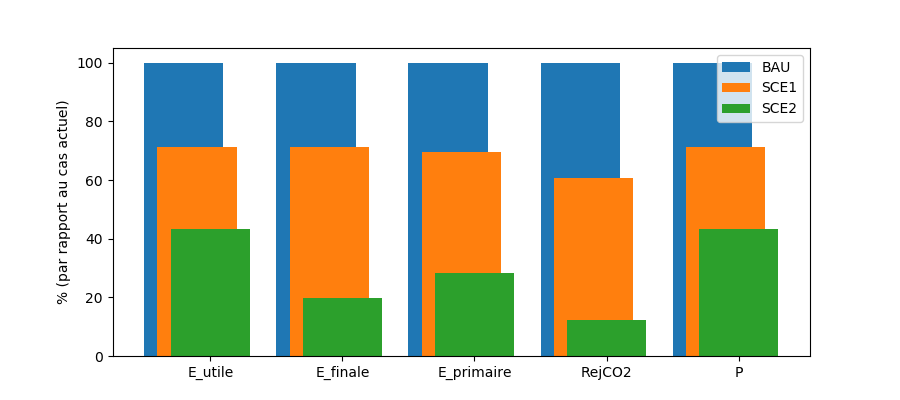

Text(0,0.5,'% (par rapport au cas actuel)')

In [31]:
plt.figure(figsize=(9, 4))

x = np.arange(5)
tlabels = [i.split("_[")[0] for i in kpi_sce1.index]

plt.bar(x=x, width=0.6, height=kpi_sce0/kpi_sce0 * 100, tick_label=tlabels, label="BAU")
plt.bar(x=x+0.1, width=0.6, height=kpi_sce1/kpi_sce0 * 100, tick_label=tlabels, label="SCE1")
plt.bar(x=x+0.2, width=0.6, height=kpi_sce2/kpi_sce0 * 100, tick_label=tlabels, label="SCE2")
plt.legend()
plt.ylabel("% (par rapport au cas actuel)")